<a href="https://colab.research.google.com/github/quicksilverri/fanfic-popularuty-prediction/blob/main/fanfic_popularity_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import staff

In [37]:
import requests as req
from bs4 import BeautifulSoup
import pandas as pd 
import seaborn as sns

# Get the data

### Create Fanfic class

It's kinda long and simple, so it's hidden. 

In [12]:
def clean(list): 
  """Extracts text from list of bs4.Tags"""

  return [item.get_text() for item in list]

In [13]:
class Fanfic: 
  def __init__(self, fanfic):
    self.fic = fanfic
    self.info = {}

    self.header = self.fic.select('.heading a')
    
    self.get_header()
    self.get_chapters()
    self.get_stats()
    self.get_date()
    self.get_tags()
    self.get_square()

  def get_header(self):
    """Sets title, author nickname and list of fandoms into self.stats dict"""
    
    title = self.header[0].get_text()
    author = self.header[1].get_text()
    fandoms = clean(self.header[2:])
     
    self.info['title'] = title
    self.info['author'] = author
    self.info['fandoms'] = fandoms

  def get_chapters(self): 
    """Sets number of chapters written and number of chapters intended
    into self.stats dict"""

    def smart_int(n):
      try: 
        return int(n)
      except:
        return None

    chapters = self.fic.select('dd.chapters')[0].get_text()
    written, total = map(smart_int, chapters.split('/'))

    self.info['written'] = written
    self.info['total'] = total

  def get_number(self, selector): 
     """Processes numerical data (removes comma so it can be turned
     into integer)"""

     if self.fic.select(selector): 

       data = self.fic.select(selector)[0].get_text()
       data = int(data.replace(',', ''))
       return data
        
     return None

  def get_stats(self): 
     """Sets data collected in Stats section (words, hits, comments,
     bookmarks, collections and language) into self.info dict"""
      
     words = self.get_number('dd.words')
     hits = self.get_number('dd.hits')
     comments = self.get_number('dd.comments')
     bookmarks = self.get_number('dd.bookmarks')
     collections = self.get_number('dd.collections')

     lang = self.fic.select('dd.language')[0].get_text()
     
     self.info['words'] = words
     self.info['hits'] = hits 
     self.info['comments'] = comments 
     self.info['bookmarks'] = bookmarks
     self.info['collections'] = collections 
     self.info['lang'] = lang

  def get_date(self):  # add date of first publishing??
    """Sets date of the most recent update into self.dict"""

    date = self.fic.select('.datetime')[0].get_text()
    self.info['date'] = date 
    
  def get_tags(self): 
    """Sets tag-like data into self.info dict"""

    characters_raw = self.fic.select('.characters a.tag')
    characters = clean(characters_raw)

    parings_raw = self.fic.select('.relationships a.tag')
    parings = clean(parings_raw)


    self.info['characters'] = characters
    self.info['parings'] = parings
    self.info['tags'] = None
    self.info['freeforms'] = None

  def get_square(self): 
    """Sets data from square to the left of fanfic title into self.info dict"""

    self.info['rating'] = None
    self.info['relationships'] = None
    self.info['completion'] = None
    self.info['warnings'] = None 

  def get_info(self):
     """Return all the data about Fanfic in a DataFrame"""

     df = pd.DataFrame([self.info])

     return df

### Create FanficParser

In [32]:
class FanficParser: 
  def __init__(self, initial_link):
    self.inlink = initial_link
    self.domain = self.get_domain()
    self.df = pd.DataFrame()
    self.link = self.inlink

  def get_domain(self):
     end_of_link = self.inlink.find('/', 8)
     domain = self.inlink[:end_of_link]
     return domain
  
  def parse_page(self): 
    page = req.get(self.link)
    soup = BeautifulSoup(page.content, 'html.parser')
    fanfics = soup.select('[role~=article]')
    
    print(f'{self.link} parsed')

    new_link_relative = soup.select('li.next a')[0].get('href')
    self.link = self.domain + new_link_relative

    return fanfics

  def parse(self, n_pages): 
    for i in range(n_pages): 
      fanfics = self.parse_page()

      for fanfic in fanfics:
        self.df = self.df.append(Fanfic(fanfic).get_info())

    print(f'total {self.df.shape[0]} fanfics')
    
    self.df.index = range(self.df.shape[0])

  def reset(self):
    self.df = pd.DataFrame()
    self.link = self.inlink
    

In [33]:
link = 'https://archiveofourown.org/tags/Marvel/works'
parser = FanficParser(link)

In [35]:
parser.parse(3)

https://archiveofourown.org/tags/Marvel/works?page=4&view_adult=true parsed
https://archiveofourown.org/tags/Marvel/works?page=5&view_adult=true parsed
https://archiveofourown.org/tags/Marvel/works?page=6&view_adult=true parsed
total 120 fanfics


In [36]:
parser.df

,title,author,fandoms,written,total,words,hits,comments,bookmarks,collections,lang,date,characters,parings,tags,freeforms,rating,relationships,completion,warnings
0,monsters,theilliterateironman,"[The Avengers (Marvel Movies), Marvel Cinemati...",5,None,4745,0,None,None,None,English,10 Jul 2022,"[Tony Stark, Nick Fury, Thor, Natasha Romanov ...","[Tony Stark & Original Character(s), Steve Rog...",None,None,None,None,None,None
1,Perhaps We Can Save Each Other: A Peter Parker...,SpiderBat1996,"[Harry Potter - J. K. Rowling, Spider-Man (Tom...",26,None,99620,9104,195,62,None,English,09 Jul 2022,"[Peter Parker, Harry Potter, Stephen Strange, ...","[Peter Parker & Harry Potter, Kate Bishop & Ha...",None,None,None,None,None,None
2,Reminiscence ( LokiXReader ),Nosayo,"[Marvel Cinematic Universe, The Avengers (Marv...",19,None,64335,177,None,2,None,English,09 Jul 2022,"[Loki (Marvel), Thor (Marvel), Tony Stark, Bru...",[Loki/OC],None,None,None,None,None,None
3,Fall if you want,glittercake,"[The Falcon and the Winter Soldier (TV), Marve...",4,4,27395,1764,46,18,None,English,09 Jul 2022,"[Sam Wilson (Marvel), James ""Bucky"" Barnes, Jo...","[James ""Bucky"" Barnes/Sam Wilson, Joaquín Torr...",None,None,None,None,None,None
4,Where the Flowers go to Wilt,Cyberpunk_69,"[Dream SMP, Minecraft (Video Game), Marvel, Vi...",1,1,537,0,None,None,None,English,09 Jul 2022,"[TommyInnit (Video Blogging RPF), Toby Smith |...",[Wilbur Soot & Technoblade & TommyInnit & Phil...,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,Unplanned Obsolescence,HickoryDaisy,[My Little Pony Generation 4: Friendship Is Ma...,1,1,1037,15,None,None,None,English,09 Jul 2022,"[Myself, Pinkie Pie (My Little Pony: Friendshi...",[],None,None,None,None,None,None
116,On our way to cure Mr Os's Ass,MaryVioletiqueWrites7708,"[Spider-Man - All Media Types, Spider-Man (Tom...",9,None,7169,689,6,2,1,English,09 Jul 2022,"[Peter Parker, Peter Benjamin Parker, Peter-Th...","[Harry Osborn & Peter Parker, Harry Osborn/Pet...",None,None,None,None,None,None
117,If Only Ikea Was Their Biggest Problem,theemdash,"[Captain America (Movies), Marvel Cinematic Un...",1,1,434,87,7,1,None,English,09 Jul 2022,"[Steve Rogers, James ""Bucky"" Barnes]","[James ""Bucky"" Barnes/Steve Rogers]",None,None,None,None,None,None
118,U boku króla Nowego Asgardu,janekburza (kas_delafere),"[Marvel, Marvel Cinematic Universe]",1,1,1045,4,None,None,None,Polski,09 Jul 2022,"[Sif (Marvel), Valkyrie]",[Sif/Valkyrie],None,None,None,None,None,None


In [ ]:
class FanficAnalyzer:
  pass 

In [ ]:
fandom_list = set()

for fandoms in df.fandoms:
  for fandom in fandoms: 
    fandom_list.add(fandom)

In [ ]:
fandom_count = {}

for fandoms in df.fandoms:
  for fandom in fandoms: 
    try: 
      fandom_count[fandom] += 1
    except: 
      fandom_count[fandom] = 1

In [ ]:
count = pd.Series(fandom_count)

In [ ]:
count = count.sort_values(ascending=False)

In [ ]:
df_count = pd.DataFrame()
df_count['count'] = count
df_count['fandom'] = count.index

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

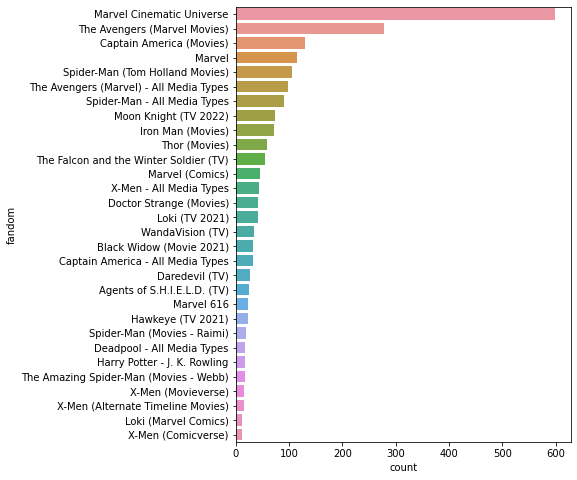

In [ ]:
plt.figure(figsize=(6, 8))
sns.barplot(data=df_count[df_count['count'] > 10], x='count', y='fandom', orient='h')

In [ ]:
len(fandom_list)

534

In [ ]:
df.fandoms[0]

'Daredevil (TV)'

# Data preprocessing 
So now we have to figure out what type of data can be suitable for our model. 

1. Replace missing values 
2. Parse dates 